In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8703703703703703, Loss: 0.7240276336669922
Checkpoint 20, Accuracy: 0.8024691358024691, Loss: 0.8009295993381076
Checkpoint 30, Accuracy: 0.8271604938271605, Loss: 0.7588450820357712
Checkpoint 40, Accuracy: 0.8703703703703703, Loss: 0.6498647619176794
Checkpoint 50, Accuracy: 0.8148148148148148, Loss: 0.6038375430636935
Checkpoint 60, Accuracy: 0.8518518518518519, Loss: 0.6344617207845052
Checkpoint 70, Accuracy: 0.845679012345679, Loss: 0.5560789461489077
Checkpoint 80, Accuracy: 0.8703703703703703, Loss: 0.5333241003530996
Checkpoint 90, Accuracy: 0.8950617283950617, Loss: 0.4483155851010923
Checkpoint 100, Accuracy: 0.8888888888888888, Loss: 0.4231190151638455
Checkpoint 110, Accuracy: 0.9012345679012346, Loss: 0.3814543264883536
Checkpoint 120, Accuracy: 0.9012345679012346, Loss: 0.3814543264883536
Checkpoint 130, Accuracy: 0.8950617283950617, Loss: 0.39555143426965783
Checkpoint 140, Accuracy: 0.9012345679012346, Loss: 0.3819137149386936
Checkpoint 150,

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

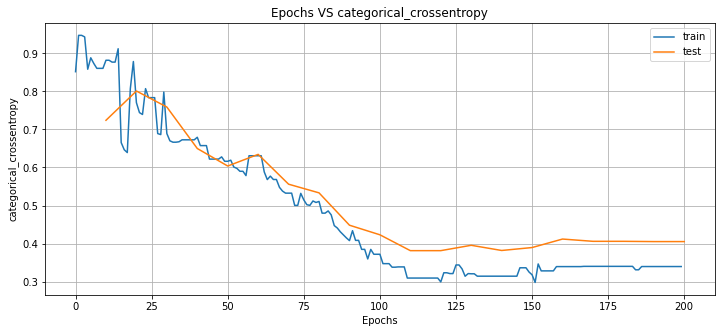

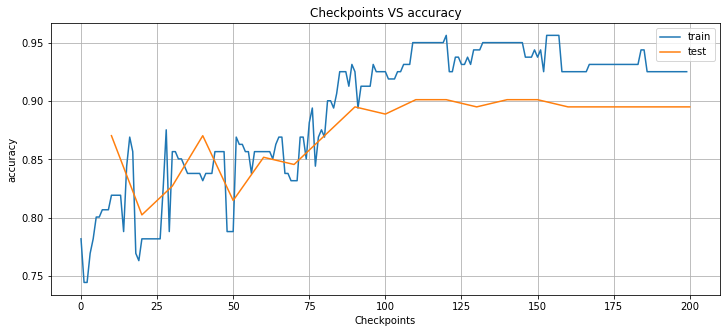

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.7885526  0.0599744  0.15147296]
[0. 0. 1.] <-> [0.8940737  0.02457031 0.08135602]
[1. 0. 0.] <-> [0.78901905 0.13342191 0.07755902]
[0. 0. 1.] <-> [0.47081444 0.0410608  0.4881248 ]
[0. 1. 0.] <-> [0.5665066  0.38671094 0.04678242]
[1. 0. 0.] <-> [0.87088823 0.03520588 0.09390589]
[1. 0. 0.] <-> [0.6969578  0.23638867 0.06665353]
[1. 0. 0.] <-> [0.9024384  0.03461405 0.06294751]
[1. 0. 0.] <-> [0.89254534 0.05116905 0.0562857 ]
[1. 0. 0.] <-> [0.60766214 0.32744804 0.0648898 ]
[1. 0. 0.] <-> [0.81419516 0.10180905 0.0839958 ]
[1. 0. 0.] <-> [0.7574525  0.17859173 0.06395586]
[1. 0. 0.] <-> [0.8181142  0.10680825 0.07507746]
[1. 0. 0.] <-> [0.8052593  0.12795544 0.06678532]
[1. 0. 0.] <-> [0.7209879  0.17697415 0.10203796]
[0. 1. 0.] <-> [0.21954006 0.73300385 0.0474561 ]
[1. 0. 0.] <-> [0.7166092  0.22610092 0.05728986]
[1. 0. 0.] <-> [0.6694455  0.2691209  0.06143365]
[0. 1. 0.] <-> [0.5476839  0.40104827 0.05126782]
[1. 0. 0.] <-> [0.8814679  0.05650138 0.06203075]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8703703703703703, 'mean_square_error': 0.3938849180636476, 'categorical_crossentropy': 0.7240276336669922, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 12, 'fp_hit': 5, 'tn_hit': 87, 'fn_hit': 4}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 10} 


{'accuracy': 0.8024691358024691, 'mean_square_error': 0.44808141632494725, 'categorical_crossentropy': 0.8009295993381076, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 27, 'tn_hit': 3, 'fn_hit': 2}, 1: {'tp_hit': 0, 'fp_hit': 5, 'tn_hit': 87, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 20} 


{'accuracy': 0.8271604938271605, 'mean_square_error': 0.42814164383549264, 'categorical_crossentropy': 0.7588450820357712, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 28, 'tn_hit': 2, 'fn_hit': 0}, 1: {'tp_hit': 2, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 14}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_h

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.5406068  -0.84897435 -0.64271724 -0.5453879  -0.5867714 ]
 bias: 0.20141081511974335

Neuron 1: weights:
[ 0.5696455  -1.2171441  -0.5624877  -0.00123223  0.39650288]
 bias: 0.2710283398628235

Neuron 2: weights:
[-0.30315977  0.7812131   0.02212977 -0.82136333 -1.017163  ]
 bias: 0.7968225479125977

Neuron 3: weights:
[-0.27533433  0.2997651   0.75449914  1.0049413   0.51091653]
 bias: 0.06254410743713379

$
Layer 2
Neuron 0: weights:
[ 1.2101222  0.7851634  1.1265395 -1.1819466]
 bias: 0.049130793660879135

Neuron 1: weights:
[-0.8689653  -1.5329194   0.65137833  0.7515244 ]
 bias: 0.31309774518013

Neuron 2: weights:
[ 0.02428541  0.89173037 -1.840426    0.51674247]
 bias: 0.03122709132730961

$

